In [1]:
!pip install torchscan

In [2]:
import os

import torch
import torch.nn as nn
import torch.nn.functional as F

from torchscan import summary

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import tqdm
from tqdm.notebook import tqdm as tqdm_nb

import warnings
warnings.filterwarnings("ignore")

# os.environ['TORCH_HOME'] = '~/pytorch/torch_home'
# os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
# os.environ["CUDA_VISIBLE_DEVICES"] = "0"

# Define Model

In [3]:
class AutoEncoder(nn.Module):
    def __init__(self, z_dim=2):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(),
            nn.Conv2d(32, 64, 3, padding=1, stride=2),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.Conv2d(64, 64, 3, padding=1, stride=2),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.Flatten(),
        )

        self.fc_mu = nn.Linear(64 * 7 * 7, z_dim)
        self.fc_var = nn.Linear(64 * 7 * 7, z_dim)

        self.decoder = nn.Sequential(
            nn.Linear(z_dim, 64 * 7 * 7),
            nn.Unflatten(1, (64, 7, 7)),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(64, 64, 3, padding=1, output_padding=1, stride=2),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(64, 32, 3, padding=1, output_padding=1, stride=2),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(32, 1, 3, padding=1),
            nn.Tanh(),
        )

        self.latent = torch.empty(z_dim)
        self.mu = None
        self.log_var = None

    def forward(self, x):
        x = self.encoder(x)
        self.mu = self.fc_mu(x)
        self.log_var = self.fc_var(x)
        std = torch.exp(0.5 * self.log_var)
        eps = torch.randn_like(std)
        z = eps * std + self.mu
        self.latent = z.clone()
        x = self.decoder(z)
        return x

In [4]:
ae = AutoEncoder()
summary(ae, (1, 28, 28))
del ae

__________________________________________________________________________________________
Layer                        Type                  Output Shape              Param #        
autoencoder                  AutoEncoder           (-1, 1, 28, 28)           0              
├─encoder                    Sequential            (-1, 3136)                0              
|    └─0                     Conv2d                (-1, 32, 28, 28)          320            
|    └─1                     BatchNorm2d           (-1, 32, 28, 28)          129            
|    └─2                     LeakyReLU             (-1, 32, 28, 28)          0              
|    └─3                     Conv2d                (-1, 64, 14, 14)          18,496         
|    └─4                     BatchNorm2d           (-1, 64, 14, 14)          257            
|    └─5                     LeakyReLU             (-1, 64, 14, 14)          0              
|    └─6                     Conv2d                (-1, 64, 7, 7)       

# Dataset & loaders

In [5]:
import torchvision.transforms as T

transform = T.Compose([
    T.ToTensor(),
    T.Normalize((0.5,), (1.0,))
])

If you want to read and **use MNIST dataset from local gzip file**, uncomment followings.

In [6]:
# import os
# import gzip

# class MNIST_local(torch.utils.data.Dataset):
#     def __init__(self, root, transform=None):
#         self.root = root
#         self.transform = transform
        
#         f_image_name = os.path.join(root, 'train-images-idx3-ubyte.gz')
#         f_label_name = os.path.join(root, 'train-labels-idx1-ubyte.gz')
#         self.fimage = gzip.open(f_image_name, 'r')
#         self.flabel = gzip.open(f_label_name, 'r')
        
#         self.magic_number = int.from_bytes(self.fimage.read(4), 'big')
#         self.image_count = int.from_bytes(self.fimage.read(4), 'big')
#         self.row_count = int.from_bytes(self.fimage.read(4), 'big')
#         self.column_count = int.from_bytes(self.fimage.read(4), 'big')
        
#         self.images = []
#         self.labels = []
        
#         self.flabel.seek(8)
#         self.fimage.seek(16)
#         img_sz = 28 * 28
#         for idx in range(self.image_count):
#             buf_label = self.flabel.read(1)
#             buf_image = self.fimage.read(img_sz)
#             label = np.frombuffer(buf_label, dtype=np.uint8).astype(np.int64)
#             image = np.frombuffer(buf_image, dtype=np.uint8).astype(np.float32)
#             image = image.reshape(1, 28, 28)
#             self.images.append(image)
#             self.labels.append(label[0])
    
#     def __del__(self):
#         self.fimage.close()
#         self.flabel.close()

#     def __len__(self):
#         return self.image_count

#     def __getitem__(self, idx):
# #         img_sz = 28 * 28
# #         self.flabel.seek(8 + idx)
# #         self.fimage.seek(16 + idx * img_sz)
# #         buf_label = self.flabel.read(1)
# #         buf_image = self.fimage.read(img_sz)
# #         label = np.frombuffer(buf_label, dtype=np.uint8).astype(np.int64)
# #         image = np.frombuffer(buf_image, dtype=np.uint8).astype(np.float32)
# #         image = image.reshape(1, 28, 28)
# #         return image, label[0]
#         return np.array(self.images[idx]), np.array(self.labels[idx])

In [7]:
# ds = MNIST_local('./MNIST')
# for i in range(5):
#     plt.figure(figsize=(1, 1))
#     plt.axis('off')
#     image, label = ds[i]
#     plt.title(label)
#     plt.imshow(np.array(image).transpose(1, 2, 0))
#     plt.show()
# del ds

In [8]:
from torchvision.datasets import MNIST

download_root = './MNIST'

train_dataset = MNIST(download_root, transform=transform, train=True, download=True)
# valid_dataset = MNIST(download_root, transform=transform, train=False, download=True)
# test_dataset = MNIST(download_root, transform=transform, train=False, download=True)

# train_dataset = MNIST_local('./MNIST')

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/MNIST/raw



In [9]:
from torch.utils.data import DataLoader

bs = 128  # batch size

train_loader = DataLoader(dataset=train_dataset, batch_size=bs, shuffle=True, num_workers=4)
# valid_loader = DataLoader(dataset=valid_dataset, batch_size=bs, shuffle=True)
# test_loader = DataLoader(dataset=test_dataset, batch_size=bs, shuffle=True)

In [10]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('device:', device)

device: cuda:0


## some utils

In [11]:
from mpl_toolkits.axes_grid1 import ImageGrid

def imgrid(array, rows, cols):
    plt.axis('off')
    plt.gcf().set_size_inches(cols, rows)
    grid = ImageGrid(plt.gcf(), 111, (rows, cols), axes_pad=0.1)
    for ax in grid: ax.axis("off")
    for ax, im in zip(grid, array):
        ax.axis('off')
        ax.imshow(im)
    return grid


In [12]:
class EarlyStopping:
    def __init__(self, patience=5):
        self.loss = np.inf
        self.patience = 0
        self.patience_limit = patience
        
    def step(self, loss):
        if self.loss > loss:
            self.loss = loss
            self.patience = 0
        else:
            self.patience += 1
    
    def is_stop(self):
        return self.patience >= self.patience_limit

In [13]:
import io
import imageio
import numpy as np
from PIL import Image
from torchvision.transforms.transforms import Lambda
from IPython.display import clear_output
from time import sleep

from torch.optim.lr_scheduler import ReduceLROnPlateau, OneCycleLR, CyclicLR

model = AutoEncoder(z_dim=2).to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=1e-6, max_lr=0.005, step_size_up=6, mode="triangular2")
early_stop = EarlyStopping()

keyframes = []
losses = []
lrs = []

model.train()
total = len(train_loader)

for epoch in range(60):
    scheduler.step()
    lr = np.array(scheduler._last_lr).flatten()[-1]
    lrs.append(lr)
    
    loss_epoch = []
    
    for idx, (inputs, outputs) in enumerate(train_loader):
        inputs = inputs.to(device)
        y_hat = model(inputs).to(device)
        mu, log_var = model.mu, model.log_var
        
        r_loss = criterion(y_hat, inputs)
        kld_loss = torch.mean(-0.5 * torch.sum(1 + log_var - mu ** 2 - log_var.exp(), dim=1))
        kl_weight = 0.00025
        kld_loss = (kld_loss * kl_weight).to(device)

        loss = r_loss + kld_loss
        loss_ = loss.detach().cpu().item()
        losses.append(loss_)
        loss_epoch.append(loss_)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        frames_per_epoch = 8 if epoch < 10 else 4
        is_record = idx % (total // frames_per_epoch) == 0

        if is_record:
            kf_wait = 0
            lab = {}
            for (i, l) in enumerate(outputs):
                label = l.item()
                if not label in lab:
                    lab[label] = i
                if len(lab) >= 10:
                    break
            if len(lab) != 10: continue
            images = torch.empty((1, 28, 28)).to(device)
            for label, i in sorted(lab.items()):
                images = torch.row_stack([images, inputs[i].view(-1, 28, 28)])
                images = torch.row_stack([images, y_hat[i].view(-1, 28, 28)])
            images = images[1:].detach().cpu().numpy()
            plt.figure()
            plt.title(f'train: {idx + 1}/{total} step(s) of {epoch + 1} epoch(s)')
            imgrid(images, 2, 10)
            img_buf = io.BytesIO()
            plt.savefig(img_buf, format='png')
            keyframes.append(np.array(plt.gcf().canvas.renderer._renderer))
            img_buf.close()
            del img_buf
            del images
#             clear_output(wait=True)
#             plt.show()
#             print(f'loss: {r_loss}, kld_loss: {kld_loss}, lr={lr}')
            plt.close()
    
    loss_epoch = np.mean(loss_epoch)
    early_stop.step(loss_epoch)
    print(f'[epoch={epoch}] avg loss: {loss_epoch}')
    if early_stop.is_stop():
        print('Ealry Stoped')
        break
    
    if loss.isnan():
        print('NaN loss is encountered')
        break

plt.show()

[epoch=0] avg loss: 0.1747632310239237
[epoch=1] avg loss: 0.09444105356677508
[epoch=2] avg loss: 0.07486108974861438
[epoch=3] avg loss: 0.061851657204218764
[epoch=4] avg loss: 0.058765787043487595
[epoch=5] avg loss: 0.05732021928786723
[epoch=6] avg loss: 0.05637411314890837
[epoch=7] avg loss: 0.055764336409027386
[epoch=8] avg loss: 0.05528734965142665
[epoch=9] avg loss: 0.054965895423884074
[epoch=10] avg loss: 0.054728298847164424
[epoch=11] avg loss: 0.054631507441179075
[epoch=12] avg loss: 0.05459065739311643
[epoch=13] avg loss: 0.05451440790505297
[epoch=14] avg loss: 0.0543610130958974
[epoch=15] avg loss: 0.054181157645068444
[epoch=16] avg loss: 0.054008099975298714
[epoch=17] avg loss: 0.05375514743424682
[epoch=18] avg loss: 0.05353201256949764
[epoch=19] avg loss: 0.05334303251652321
[epoch=20] avg loss: 0.053184138440183486
[epoch=21] avg loss: 0.053068245628050396
[epoch=22] avg loss: 0.0529878215828557
[epoch=23] avg loss: 0.052949648922376795
[epoch=24] avg los

In [14]:
model.latent.shape

torch.Size([96, 2])

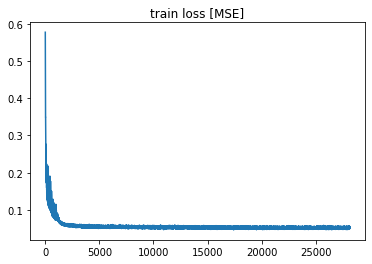

In [15]:
plt.title('train loss [MSE]')
sns.lineplot(x=range(len(losses)), y=losses)
plt.show()

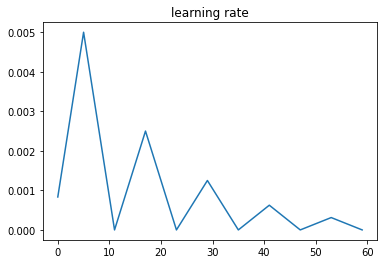

In [16]:
plt.title('learning rate')
lrs = np.array(lrs).reshape(-1).tolist()
sns.lineplot(x=range(len(lrs)), y=lrs)
plt.show()

# Sample Output

In [17]:
imageio.mimsave('./mnist_vae.gif', keyframes)
del keyframes

![Animated GIF](./mnist_vae.gif)

In [18]:
model.eval()

latents_xy = None
latents_c = None

for inputs, outputs in tqdm_nb(train_loader):
    inputs = inputs.to(device)
    y_hat = model(inputs).to(device)
    latent = model.latent
    
    xys = latent.detach().cpu()
    labels = outputs.detach().cpu().reshape(-1, 1)
    if latents_xy == None:
        latents_xy = xys
        latents_c = labels
    else:
        latents_xy = torch.row_stack([latents_xy, xys])
        latents_c = torch.row_stack([latents_c, labels])

  0%|          | 0/469 [00:00<?, ?it/s]

![](./mnist_z2.gif)


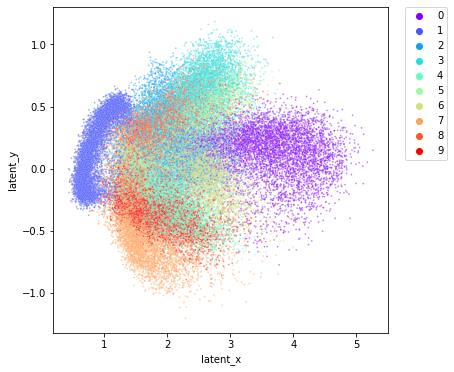

In [19]:
df = pd.DataFrame({'latent_x': latents_xy[:, 0], 'latent_y': latents_xy[:, 1], 'label': latents_c[:, 0]})
plt.figure(figsize=(6, 6))
sns.scatterplot(data=df, x='latent_x', y='latent_y', hue='label', palette='rainbow', s=3, alpha=.5, legend='full')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

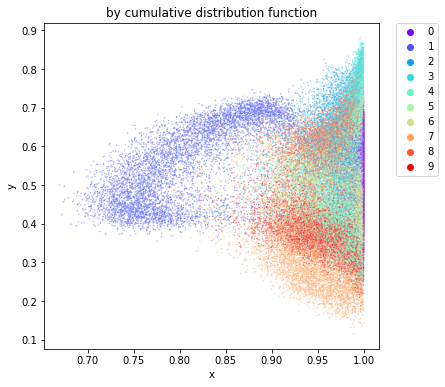

In [20]:
import scipy
rv = scipy.stats.norm(loc=0, scale=1)
df_cdf = pd.DataFrame({'x': rv.cdf(latents_xy[:, 0]), 'y': rv.cdf(latents_xy[:, 1]), 'label': latents_c[:, 0]})
plt.figure(figsize=(6, 6))
plt.title('by cumulative distribution function')
sns.scatterplot(data=df_cdf, x='x', y='y', hue='label', palette='rainbow', s=2, alpha=.5, legend='full')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

In [21]:
import matplotlib.patches as patches

def show_sample(model, xy, c, width, height, dense):
    xs = xy[:, 0].detach().cpu().numpy()
    ys = xy[:, 1].detach().cpu().numpy()
    xy_samples = []
    w, h = width[1] - width[0], height[1] - height[0]
    x_ticks = np.arange(width[0], width[1] + w / dense, w / dense) # closing range
    y_ticks = np.arange(height[1], height[0] - h / dense, -h / dense) # flip Y (plot default)
    for y in y_ticks[:dense]:
        for x in x_ticks[:dense]:
            xy_samples.append((x, y))
    xy_samples = np.array(xy_samples).astype(np.float32)

    df_sample = pd.DataFrame({'x': xy_samples[:, 0], 'y': xy_samples[:, 1]})

    fig, axes = plt.subplots(1, 2, figsize=(16, 8))
    
    axes[0].set_title('Sample points')
    sns.scatterplot(data=df, x='latent_x', y='latent_y', hue='label', palette='rainbow', s=1, alpha=.5, ax=axes[0], legend='full')
    # sns.scatterplot(data=df_sample, x='x', y='y', color='black', s=5, ax=axes[0])
    rect = patches.Rectangle((width[0], height[0]), w, h, linewidth=1, edgecolor='black', facecolor='none')
    axes[0].add_patch(rect)
    axes[0].legend(bbox_to_anchor=(0.95, 1), loc=2, borderaxespad=0.)

    model.eval()

    sample_inputs = torch.tensor(xy_samples).to(device)
    sample_outputs = model.decoder(sample_inputs).detach().cpu().numpy()
    sample_images = sample_outputs.reshape(-1, 28, 28)
    
    str_tick = lambda n: '{:.3f}'.format(n)

    axes[1].set_title('Output by Decoder')
    axes[1].set_xticks([0, 1, 2])
    axes[1].set_yticks([0, 1, 2])
    axes[1].set_xticklabels(list(map(str_tick, [np.min(x_ticks), np.median(x_ticks), np.max(x_ticks)])))
    axes[1].set_yticklabels(list(map(str_tick, [np.min(y_ticks), np.median(y_ticks), np.max(y_ticks)])))
    
    grid = ImageGrid(axes[1].figure, 122, (dense, dense))
    for (ax, im) in zip(grid, sample_images):
        ax.axis('off')
        ax.imshow(im, cmap='gray_r')
    for direction in ["left", "right", "bottom", "top"]:
        axes[1].spines[direction].set_visible(False)

    return fig

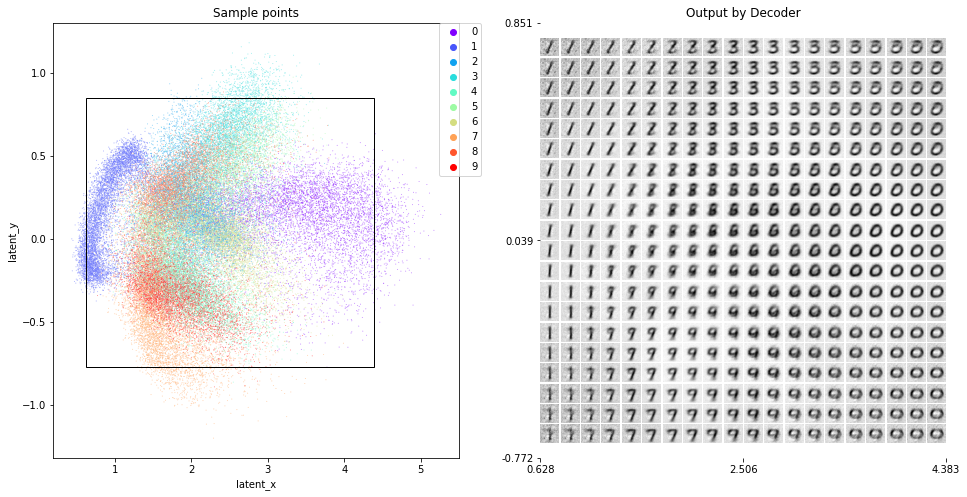

In [22]:
# Images for all
# min_x, max_x = df.latent_x.describe()[['min', 'max']]
# min_y, max_y = df.latent_y.describe()[['min', 'max']]
min_x, max_x = df.latent_x.quantile(0.01), df.latent_x.quantile(0.99)
min_y, max_y = df.latent_y.quantile(0.01), df.latent_y.quantile(0.99)
show_sample(model, latents_xy, latents_c, (min_x, max_x), (min_y, max_y), 20)
plt.show()

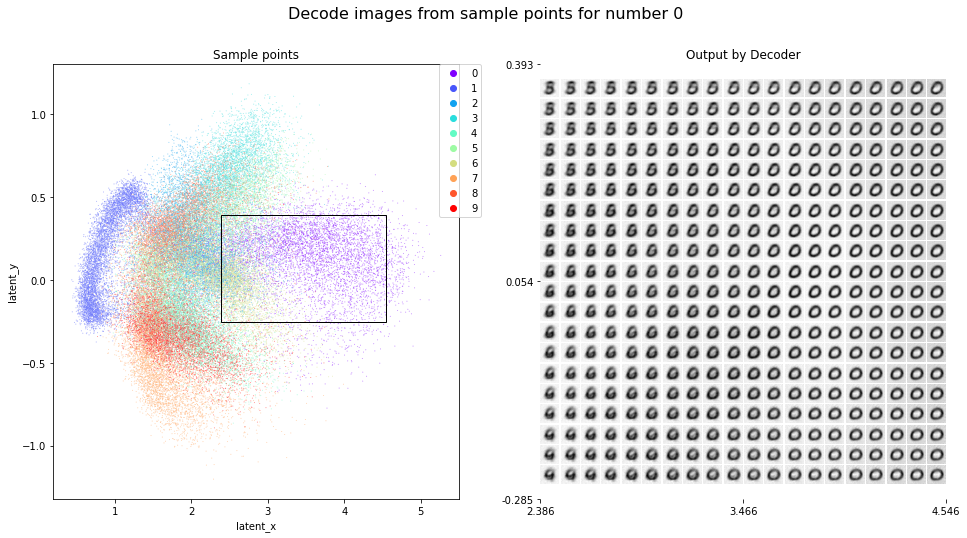

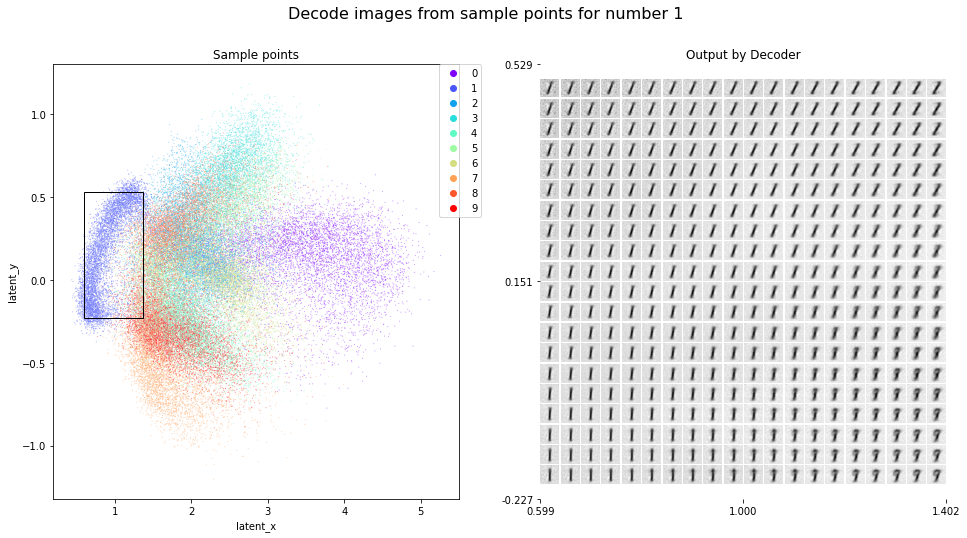

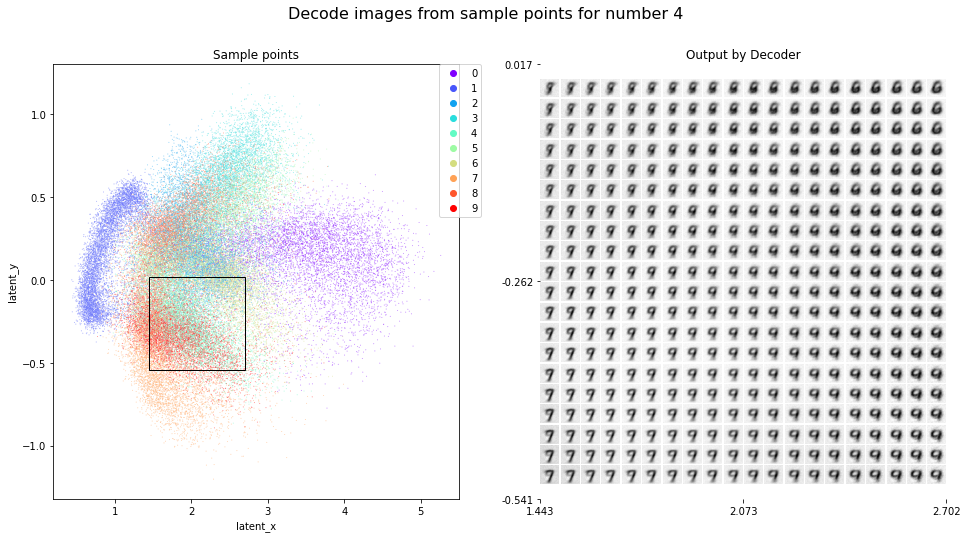

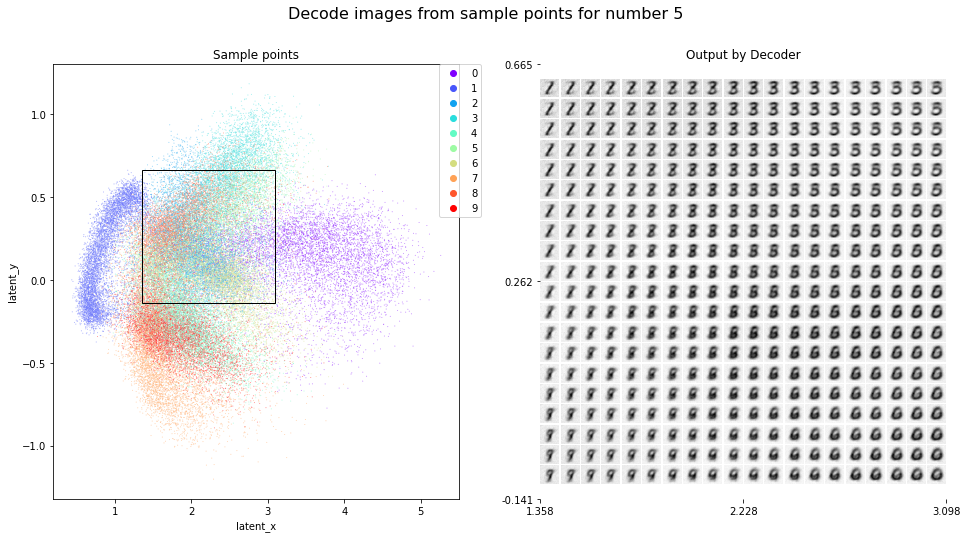

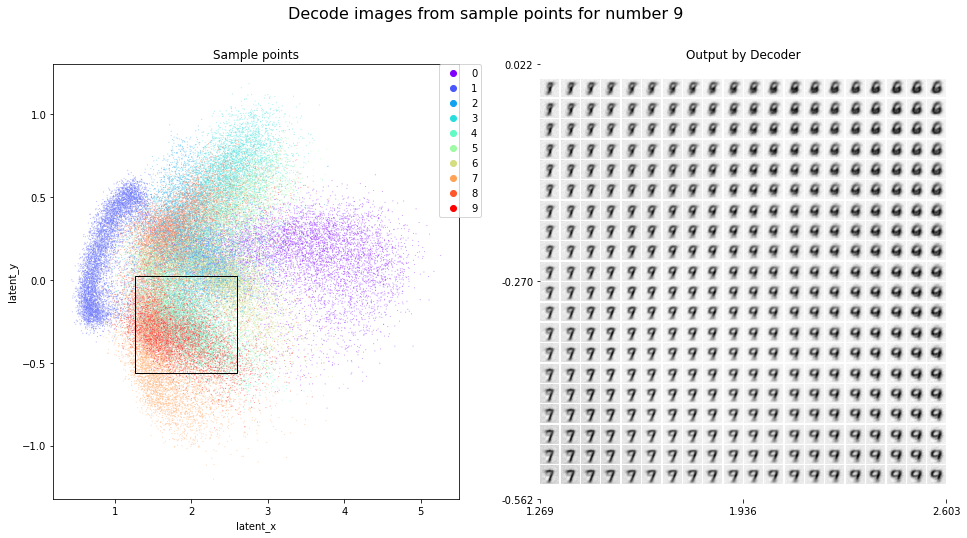

In [23]:
# for label 0
for k in [0, 1, 4, 5, 9]:
    view_x = df[df.label == k]['latent_x']
    view_y = df[df.label == k]['latent_y']
    min_x, max_x = view_x.quantile(0.05), view_x.quantile(0.95)
    min_y, max_y = view_y.quantile(0.05), view_y.quantile(0.95)
    fig = show_sample(model, latents_xy, latents_c, (min_x, max_x), (min_y, max_y), 20)
    fig.suptitle(f'Decode images from sample points for number {k}', fontsize=16)
    plt.show()